In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.nn import sigmoid

import time

In [2]:
EPS = 1e-10
fontsize=13

In [3]:
import sys
sys.path.append('../')
import adaprobe

# Vary number of stimuli

In [4]:
Ns = [2, 4, 8, 16, 32, 64]
num_targets_all = [1, 2, 4, 8, 16, 32, 64]

In [5]:
fit_options = {
    'iters': 50,
    'num_mc_samples': 20
}

In [6]:
sigma = 1
K = 500
powers = np.arange(10, 51, 10)
a = 0.5
num_repeats = 20

error_matrix = -1 * np.ones((len(Ns), len(num_targets_all), num_repeats))

tstart = time.time()
for idxn, N in enumerate(Ns):
    for idxs, num_targets in enumerate(num_targets_all):
        if num_targets > N:
            continue
        for rep in range(num_repeats):
            print('pop size: %i,  num_targets: %i,  run: %i\t'%(N, num_targets, rep), end='\r')

            # generate simulation
            phi_1 = np.random.uniform(2.5, 5.5, N)
            sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)
            sim.simulate_multistim(trials=K, num_targets=np.min([num_targets, N]), powers=powers)

            # configure priors
            phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
            phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])

            priors = {
                'beta': 7e0 * np.ones(N),
                'mu': np.zeros(N),
                'phi': phi_prior,
                'phi_cov': phi_cov_prior
            }

            stimulus_matrix = np.zeros((N, K))
            for n in range(N):
                locs = np.where(sim.tars == n)[0]
                stimulus_matrix[n, locs] = sim.I[locs]

            model = adaprobe.Model(sim.cell_locs, priors=priors)
            model.fit(sim.y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

            error_matrix[idxn, idxs, rep] = np.mean(np.abs(sim.w - model.state['mu'] * model.state['alpha']))
tend = time.time()
print('%.2f'%((tend-tstart)/60))

30.09ize: 64,  num_targets: 64,  run: 19	


In [7]:
means = np.mean(accuracy, axis=-1)
sdevs = np.std(accuracy, axis=-1)

fontsize=12

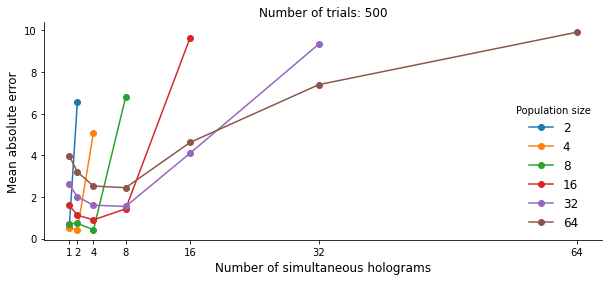

In [8]:
plt.figure(figsize=(10, 4))
for N in range(len(Ns)):
    num_pts = len(np.where(means[N] > -1)[0])
    plt.plot(num_targets_all[:num_pts], means[N][:num_pts], 'o-', color='C%i'%N)
#     plt.fill_between(num_targets_all[:num_pts], means[N][:num_pts] - sdevs[N][:num_pts], means[N][:num_pts] + sdevs[N][:num_pts], facecolor='C%i'%N, edgecolor='None', alpha=0.2)
plt.xticks(num_targets_all)
plt.legend(Ns, frameon=False, title='Population size', fontsize=fontsize)
plt.ylabel('Mean absolute error', fontsize=fontsize)
plt.xlabel('Number of simultaneous holograms', fontsize=fontsize)
plt.title('Number of trials: %i'%K)
for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)

# plt.savefig('figs/multi_spot_mapping_offline_err_vs_nstim_K%i.png'%K, format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()